# Machine Learning Project
# Kansas City Crime Data Deep Dive

### Import Dependancies

In [1]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from pandas import datetime
from dateutil import parser
from scipy import stats
import os

### Obtain KCMO crime data (Raw data came from data.kcmo.org)

In [2]:
file_name = os.path.join('Resources', 'KCPD_Crime_Data_2017.csv')
kc_crime = pd.read_csv(file_name)
kc_crime.reset_index()
kc_crime.head()

,Report_No,Reported_Date,Reported_Time,From_Date,From_Time,To_Date,To_Time,Offense,IBRS,Description,...,Rep_Dist,Area,DVFlag,Invl_No,Involvement,Race,Sex,Age,Firearm Used Flag,Location
0,100080848,5/28/2017,3:44,5/28/2017,2:00,NaN,NaN,1352,280,Stolen_Property,...,PJ3255,CPD,U,1,VIC,W,F,29.0,N,4000 MILL ST\r\nKANSAS CITY 64111\r\n(39.05363...
1,120046817,11/21/2017,13:30,11/20/2017,9:00,NaN,NaN,101,09A,Homicide_Non_Negl,...,PJ1029,CPD,U,1,SUS,B,M,NaN,Y,1100 LOCUST ST\r\nKANSAS CITY 64105\r\n(39.100...
2,120046817,11/21/2017,13:30,11/20/2017,9:00,NaN,NaN,101,09A,Homicide_Non_Negl,...,PJ1029,CPD,N,1,VIC,B,F,69.0,Y,1100 LOCUST ST\r\nKANSAS CITY 64105\r\n(39.100...
3,120085080,4/27/2017,11:12,NaN,NaN,NaN,NaN,201,11A,Rape,...,NaN,NaN,U,1,VIC,B,F,21.0,N,99999\r\n
4,120085080,4/27/2017,11:12,NaN,NaN,NaN,NaN,201,11A,Rape,...,NaN,NaN,U,1,SUS,B,M,52.0,N,99999\r\n


### Features in dataset

* Age
* Date
* Time
* Crime
* Zip
* Firearm Involved
* Geolocation
* Gender

In [3]:
kc_crime.shape

(132131, 24)

### Rename & drop columns

In [4]:
kc_crime.rename(columns={'Zip Code':'zip_code'}, inplace=True)
kc_crime_dropped_columns = kc_crime.drop(['Report_No', 'To_Date', 'From_Date', 'To_Time', 'From_Time',
                          'Offense', 'IBRS', 'Rep_Dist', 'Area', 'Beat', 'DVFlag', 'Address','Invl_No'], axis=1)

### Filter for male and female victims age 90 and under in KCMO

In [5]:
kc_crime_clean_zips = kc_crime_dropped_columns[kc_crime_dropped_columns.zip_code != 99999]
only_kc_crime = kc_crime_clean_zips[kc_crime_clean_zips.City.str.contains("KANSAS CITY") == True]

victims = only_kc_crime[only_kc_crime.Involvement.str.contains("VIC") == True]

victims_no_nans = victims[victims.Sex.str.contains("NaN") == False]
male_female_victims_kcmo = victims_no_nans[victims_no_nans.Sex.str.contains("U") == False]

kc_crime_real_ages = male_female_victims_kcmo[male_female_victims_kcmo['Age'] < 91]

### Copy kc_crime_real_ages and separate "Location" into 3 columns

In [6]:
kc_crime_real_ages_copy = kc_crime_real_ages.copy()
kc_crime_real_ages_copy.head(1)

,Reported_Date,Reported_Time,Description,City,zip_code,Involvement,Race,Sex,Age,Firearm Used Flag,Location
0,5/28/2017,3:44,Stolen_Property,KANSAS CITY,64111,VIC,W,F,29.0,N,4000 MILL ST\r\nKANSAS CITY 64111\r\n(39.05363...


# Split out geo data

In [7]:
location_only = kc_crime_real_ages_copy['Location'].str[0:-1].str.split('\n', expand=True)
location_only.columns = ("address", "city_zip", "geo")
location_only.head(1)

,address,city_zip,geo
0,4000 MILL ST\r,KANSAS CITY 64111\r,"(39.053635, -94.595998"


### Parsing out latitude and longitude

In [8]:
location_only['geo'] = location_only['geo'].str[1:]
geo_split = location_only['geo'].str[0:].str.split(', ', expand=True)
geo_split.columns = ("Latitude", "Longitude")
geo_split.head(1)

,Latitude,Longitude
0,39.053635,-94.595998


In [9]:
kc_crime_real_ages_copy.count()

Reported_Date        43030
Reported_Time        43030
Description          43030
City                 43030
zip_code             43030
Involvement          43030
Race                 43030
Sex                  43030
Age                  43030
Firearm Used Flag    43030
Location             43030
dtype: int64

In [10]:
geo_split.count()

Latitude     32283
Longitude    32283
dtype: int64

In [11]:
kcmo_crime_with_nans = pd.concat([kc_crime_real_ages_copy, geo_split], axis=1)
kcmo_crime_with_nans.head(1)

,Reported_Date,Reported_Time,Description,City,zip_code,Involvement,Race,Sex,Age,Firearm Used Flag,Location,Latitude,Longitude
0,5/28/2017,3:44,Stolen_Property,KANSAS CITY,64111,VIC,W,F,29.0,N,4000 MILL ST\r\nKANSAS CITY 64111\r\n(39.05363...,39.053635,-94.595998


In [12]:
kcmo_crime_with_nans.count()

Reported_Date        43030
Reported_Time        43030
Description          43030
City                 43030
zip_code             43030
Involvement          43030
Race                 43030
Sex                  43030
Age                  43030
Firearm Used Flag    43030
Location             43030
Latitude             32283
Longitude            32283
dtype: int64

In [13]:
kcmo_crime_no_lat_nans = kcmo_crime_with_nans[kcmo_crime_with_nans.Latitude.str.contains("NaN") == False]
kcmo_crime_no_nans = kcmo_crime_no_lat_nans[kcmo_crime_no_lat_nans.Longitude.str.contains("NaN") == False]
kc_crime_for_visualizations = kcmo_crime_no_nans.drop(['City', 'Involvement', 'Location'], axis=1)
kc_crime_for_visualizations.head(1)

,Reported_Date,Reported_Time,Description,zip_code,Race,Sex,Age,Firearm Used Flag,Latitude,Longitude
0,5/28/2017,3:44,Stolen_Property,64111,W,F,29.0,N,39.053635,-94.595998


### Change time to datetime and extract hour

In [14]:
kc_crime_for_visualizations.Reported_Date = pd.to_datetime(kc_crime_for_visualizations.Reported_Date)
kc_crime_for_visualizations.Reported_Time = pd.to_datetime(kc_crime_for_visualizations.Reported_Time)
kc_crime_for_visualizations["Reported_Time"] = kc_crime_for_visualizations["Reported_Time"].dt.floor('h')
kc_crime_for_visualizations['Reported_Time'] = kc_crime_for_visualizations['Reported_Time'].dt.hour

In [15]:
kc_crime_for_visualizations.columns = ( "Date", "Hour", "Crime", "Zip", "Race", "Sex", "Age", "Firearm", "Latitude", "Longitude")
kc_crime_for_visualizations = kc_crime_for_visualizations.reset_index(drop=True)
kc_crime_for_visualizations.head()

,Date,Hour,Crime,Zip,Race,Sex,Age,Firearm,Latitude,Longitude
0,2017-05-28,3,Stolen_Property,64111,W,F,29.0,N,39.053635,-94.595998
1,2017-11-21,13,Homicide_Non_Negl,64105,B,F,69.0,Y,39.10091,-94.577328
2,2017-08-02,13,Auto_Theft,64119,W,F,31.0,N,39.17744,-94.572069
3,2017-08-24,16,Intimidation,64130,W,F,19.0,N,39.033505,-94.547812
4,2017-03-15,14,Auto_Theft,64157,W,F,62.0,N,39.235881,-94.466171


In [16]:
kc_crime_for_visualizations.shape

(32283, 10)

In [17]:
kc_crime_for_visualizations.dtypes

Date         datetime64[ns]
Hour                  int64
Crime                object
Zip                   int64
Race                 object
Sex                  object
Age                 float64
Firearm              object
Latitude             object
Longitude            object
dtype: object

In [18]:
kc_crime_for_visualizations['Month'] = kc_crime_for_visualizations.Date.map(lambda x: x.strftime('%m'))

In [19]:
kc_crime_for_visualizations.head(1)

,Date,Hour,Crime,Zip,Race,Sex,Age,Firearm,Latitude,Longitude,Month
0,2017-05-28,3,Stolen_Property,64111,W,F,29.0,N,39.053635,-94.595998,05


In [20]:
kc_crime_for_visualizations.count()

Date         32283
Hour         32283
Crime        32283
Zip          32283
Race         32283
Sex          32283
Age          32283
Firearm      32283
Latitude     32283
Longitude    32283
Month        32283
dtype: int64

In [21]:
kc_crime_for_visualizations.shape

(32283, 11)

### Confirming Clean Data in Excel

In [22]:
kc_crime_for_visualizations.to_csv('kc_crime_for_visualizations.csv', index=False)

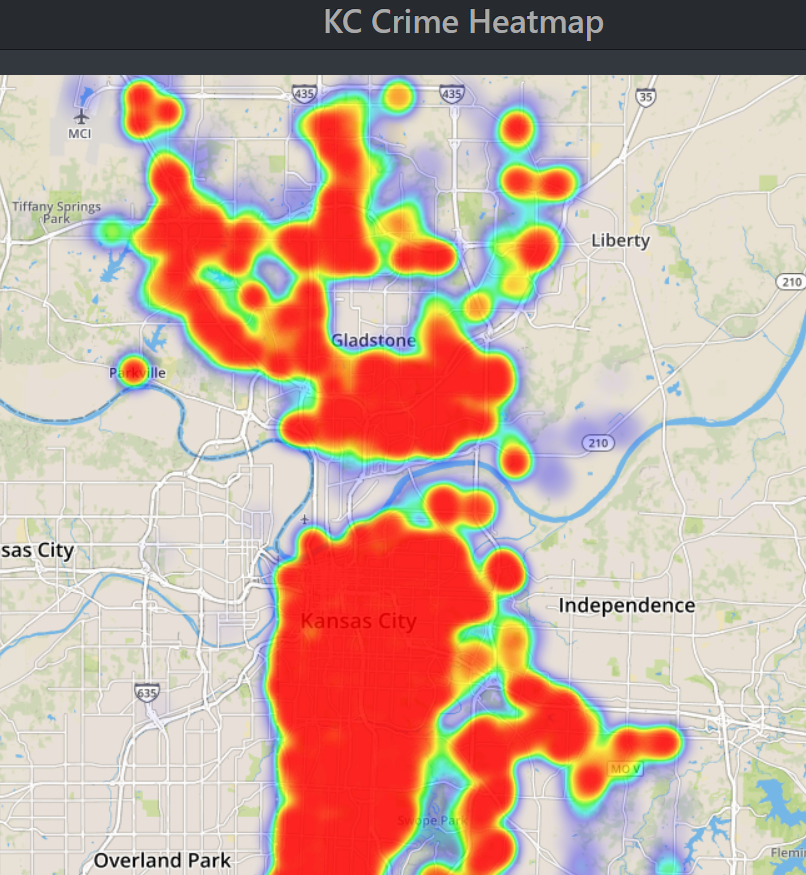